In [1]:
import math
import time
import ffmpeg
import numpy as np

import torch
import cv2

from inference import video_to_roll_inference, roll_to_midi_inference

from ultralytics import YOLO
from models.video_to_roll import resnet18
from models.roll_to_midi import Generator
import glob


In [2]:
def video_to_roll_load_model(device):
    model_path = "./data/model/video_to_roll_best_f1.pth"
    
    model = resnet18().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    return model


def roll_to_midi_load_model(device, input_shape):
    model_path = "./data/model/roll_to_midi.tar"
    
    weights = torch.load(model_path, map_location=device)
    model = Generator(input_shape).cuda()
    model.load_state_dict(weights['state_dict_G'])
    
    return model


def piano_detection_load_model(device):
    model_path = "./data/model/piano_detection.pt"
    
    model = YOLO(model_path)
    model.to(device)
    dummy_for_warmup = np.random.rand(720, 1280, 3)
    model.predict(source=dummy_for_warmup, device='0', verbose=False)    
    return model


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

video_to_roll_model = video_to_roll_load_model(device=device)
roll_to_midi_model = roll_to_midi_load_model(device=device, input_shape = (1, 65 - 15 + 1, 2 * 50))
piano_detection_model = piano_detection_load_model(device=device)

In [18]:
import atexit
import random
import cv2
import imageio
import numpy as np

class VideoReader:
    def __init__(self, video_path):
        self.video_path = video_path
        self.reader = None
        self.metadata = None
        self.read_video()
        self.make_metadata()
    
    def read_video(self):
        if self.reader is None:
            reader = imageio.get_reader(self.video_path, 'ffmpeg')

            def exit_handler():
                reader.close()
            
            atexit.register(exit_handler)
            self.reader = reader
        else:
            pass

    def make_metadata(self):
        if self.metadata is None:
            self.metadata = self.reader.get_meta_data()
            cap = cv2.VideoCapture(self.video_path)
            self.metadata['nframes'] = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    def get_frame(self, idx):
        return np.asarray(self.reader.get_data(idx), dtype="uint8")
    
    def get_all_frames(self):
        for f in self.reader:
            yield np.asarray(f, dtype="uint8")
        

video_path = "./data/inference/01.mp4"
video_reader = VideoReader(video_path=video_path)

In [20]:
for f in video_reader.get_all_frames():
    print(f)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...


KeyboardInterrupt: 

: 

In [10]:
int(267.72 * 25)

6693

In [4]:
probe = ffmpeg.probe("./data/inference/01.mp4")
video_info = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)      

video_fps = int(math.ceil(int(video_info['r_frame_rate'].split('/')[0]) / int(video_info['r_frame_rate'].split('/')[1])))
video_info['video_select_range'] = (0, 200)
video_info['video_fps'] = video_fps
video_info['video_select_frame'] = video_info['video_select_range'][1] * video_fps - video_info['video_select_range'][0] * video_fps

In [5]:
import concurrent.futures
import warnings
warnings.filterwarnings('ignore')

def process_frame(frame, xmin, ymin, xmax, ymax):
    frame = frame[ymin:ymax, xmin:xmax]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.resize(frame, (900, 100), interpolation=cv2.INTER_LINEAR) / 255.
    return frame

def preprocess(model, video_info, key):
    total_st = time.time()
    if key == 'url': video_path = "./data/inference/01.mp4"
    else: video_path = "./data/inference/02.mp4"
    
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=6)

    cap = cv2.VideoCapture(video_path)
    start, end = video_info['video_select_range'][0] * video_info['video_fps'], video_info['video_select_range'][1] * video_info['video_fps']
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, start)
    
    frames = []
    frame_count = start
    key_detected = False
    st = time.time()
    results = []
    while True:      
        if frame_count < end:
            frame_count += 1
            ret, frame = cap.read()
            # Piano Detection
            if not key_detected:
                pred = model.predict(source=frame, device="0", verbose=False)
                if pred[0].boxes:
                    if pred[0].boxes.conf.item() > 0.8:
                        xmin, ymin, xmax, ymax = tuple(np.array(pred[0].boxes.xyxy.detach().cpu()[0], dtype=int))
                        key_detected = True
                        future = executor.submit(process_frame, frame, xmin, ymin, xmax, ymax)
                        results.append(future)                        
                        continue
            else:               
                future = executor.submit(process_frame, frame, xmin, ymin, xmax, ymax)
                results.append(future)
        elif (not ret) or (frame_count >= end):
            break

    frames = executor.map(concurrent.futures.Future.result, results)
        
    ed = time.time()
    print(f"time to video read : {ed-st:.4f} s")
    executor.shutdown()

    st = time.time()
    frames = np.stack(frames, axis=0)
    ed = time.time()
    print(f"time to stack : {ed-st:.4f} s")

    # 5 frame 씩
    st = time.time()
    frames_with5 = []
    for i in range(len(frames)):
        if i >= 2 and i < len(frames)-2:
            file_list = [frames[i-2], frames[i-1], frames[i], frames[i+1], frames[i+2]]
        elif i < 2:
            file_list = [frames[i], frames[i], frames[i], frames[i+1], frames[i+2]]
        else:
            file_list = [frames[i-2], frames[i-1], frames[i], frames[i], frames[i]]
        frames_with5.append(file_list)
    ed = time.time()
    print(f"time to making chunks : {ed-st:.4f} s")
    
    total_ed = time.time()
    print(f"time to total : {total_ed-total_st:.4f} s")
    return frames_with5

In [6]:
frames_with5 = preprocess(piano_detection_model, video_info, key='url')

time to video read : 10.5187 s
time to stack : 1.8015 s
time to making chunks : 0.0083 s
time to total : 12.3616 s


In [8]:
from models.make_wav import MIDISynth
from torch.autograd import Variable

def video_to_roll_inference(video_info, frames_with5):
    min_key, max_key = 0, 84
    threshold = 0.6

    batch_size = 32
    preds_roll, preds_logit = [], []
    for idx in range(0, len(frames_with5), batch_size):
        batch_frames = torch.stack([torch.Tensor(np.asarray(frames_with5[i])).float().cuda() for i in range(idx, min(len(frames_with5), idx+batch_size))])
        pred_logits = video_to_roll_model(batch_frames)
        pred_roll = torch.sigmoid(pred_logits) >= threshold   
        numpy_pred_roll = pred_roll.cpu().detach().numpy().astype(np.int_)
        numpy_pred_logit = pred_logits.cpu().detach().numpy()
        
        for roll, logit in zip(numpy_pred_roll, numpy_pred_logit):
            preds_roll.append(roll)
            preds_logit.append(logit)

    preds_roll = np.asarray(preds_roll).squeeze()
    if preds_roll.shape[0] != video_info['video_select_frame']:
        temp = np.zeros((video_info['video_select_frame'], max_key-min_key+1))
        temp[:preds_roll.shape[0], :] = preds_roll[:video_info['video_select_frame'], :]
        preds_roll = temp
    
    roll = np.zeros((video_info['video_select_frame'], 88))
    roll[:, min_key:max_key+1] = preds_roll
    
    preds_logit = np.asarray(preds_logit).squeeze()
    if preds_logit.shape[0] != video_info['video_select_frame']:
        temp = np.zeros((video_info['video_select_frame'], max_key-min_key+1))
        temp[:preds_logit.shape[0], :] = preds_logit[:video_info['video_select_frame'], :]
        preds_logit = temp

    logit = np.zeros((video_info['video_select_frame'], 88))
    logit[:, min_key:max_key+1] = preds_logit
    
    wav, pm = MIDISynth(roll=roll, midi=None, frame=video_info['video_select_frame'], is_midi=False).process_roll()

    return roll, logit, wav, pm

def roll_to_midi_inference(video_info, logit):
    
    min_key, max_key = 15, 65
    frame = 50
    input_shape = (1, max_key - min_key + 1, 2 * frame)

    
    data = [torch.from_numpy(logit[i:i+frame]) for i in range(0, len(logit), frame)]

    final_data = []    
    for i in range(0, len(data), 2):
        if i + 1 < len(data):
            one_roll = data[i]
            two_roll = data[i+1]
            final_roll = torch.cat([one_roll, two_roll], dim=0)
            final_data.append(final_roll)

    results = []
    for i, data in enumerate(final_data):
        roll = torch.unsqueeze(torch.unsqueeze(torch.sigmoid(data.T.float().cuda()), dim=0), dim=0)
        with torch.no_grad():
            roll_to_midi_model.eval()
            
            roll = roll.type(torch.cuda.FloatTensor)
            roll_ = Variable(roll)
            
            gen_img = roll_to_midi_model(roll_)
            gen_img = gen_img >= 0.5

            numpy_pre_label = gen_img.cpu().detach().numpy().astype(np.int_)
            numpy_pre_label = np.transpose(numpy_pre_label.squeeze(), (1, 0))

            results.append(numpy_pre_label[:frame, :])
            results.append(numpy_pre_label[frame:, :])
    
    midi = np.concatenate(results, axis=0)
    wav, pm = MIDISynth(roll=None, midi=midi, frame=midi.shape[0], is_midi=True).process_midi()
    
    return midi, wav, pm


In [9]:
roll, logit, roll_wav, pm_roll = video_to_roll_inference(video_info, frames_with5)

fluidsynth: warning: Failed to pin the sample data to RAM; swapping is possible.


In [12]:
min_key, max_key = 15, 65
over_max = roll[..., max_key:].copy()
over_max[over_max > 0]


array([          1])

In [10]:
midi_wav, wav, pm_midi = roll_to_midi_inference(video_info, logit)

fluidsynth: warning: Failed to pin the sample data to RAM; swapping is possible.


In [68]:
import os
from music21 import converter, instrument, note, stream, chord

# 오선지기준으로

def extract_right_hand(score):
    right_hand_score = score.chordify()
    for element in right_hand_score.recurse():
        if isinstance(element, note.Note):
            if element.lyric is None or "right" not in element.lyric:
                element.activeSite = None
        elif isinstance(element, note.Rest):
            if element.lyric is None or "right" not in element.lyric:
                element.activeSite = None
        elif isinstance(element, chord.Chord):
            element.activeSite = None
    return right_hand_score

def extract_left_hand(score):
    left_hand_score = score.chordify()
    for element in left_hand_score.recurse():
        if isinstance(element, note.Note):
            if element.lyric is not None and "right" in element.lyric:
                element.activeSite = None
        elif isinstance(element, note.Rest):
            if element.lyric is not None and "right" in element.lyric:
                element.activeSite = None
        elif isinstance(element, chord.Chord):
            element.activeSite = None
    return left_hand_score

output_dir = "./data/outputs"
os.makedirs(output_dir, exist_ok=True)
output_roll_midi_path = os.path.join(output_dir, "pm_roll.midi")
output_midi_path = os.path.join(output_dir, "pm.midi")
pm_roll.write(output_roll_midi_path)
pm_midi.write(output_midi_path)

roll_score = converter.parse(output_roll_midi_path)
midi_score = converter.parse(output_midi_path)

right_hand_score = extract_right_hand(roll_score)
left_hand_score = extract_left_hand(roll_score)

combined_score = stream.Score()
right_hand_part = stream.Part()
right_hand_part.append(right_hand_score)
left_hand_part = stream.Part()
left_hand_part.append(left_hand_score)

combined_score.insert(0, right_hand_part)
combined_score.insert(0, left_hand_part)

roll_pdf = os.path.join(output_dir, "roll_sheet_combined")
roll_png = os.path.join(output_dir, "roll_sheet_combined")
midi_pdf = os.path.join(output_dir, "midi_sheet_combined")

converter.subConverters.ConverterLilypond().write(combined_score, fmt='png', fp=roll_png, subformats='png')
# converter.subConverters.ConverterLilypond().write(combined_score, fmt='pdf', fp=roll_pdf, subformats='pdf')


Changing working directory to: `data/outputs'
Processing `data/outputs/roll_sheet_combined'
Parsing...
Interpreting music...[8][16][24][32][40][48][56][64][72][80]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `roll_sheet_combined.eps'...
Converting to PNG...
Layout output to `roll_sheet_combined-1.eps'...
Layout output to `roll_sheet_combined-2.eps'...
Layout output to `roll_sheet_combined-3.eps'...
Layout output to `roll_sheet_combined-4.eps'...
Layout output to `roll_sheet_combined-5.eps'...
Layout output to `roll_sheet_combined-6.eps'...
Layout output to `roll_sheet_combined-7.eps'...
Layout output to `roll_sheet_combined-8.eps'...
Layout output to `roll_sheet_combined-9.eps'...
Layout output to `roll_sheet_combined-10.eps'...
Layout output to `roll_sheet_combined-11.eps'...
Layout output to `roll_sheet_combined-12.eps'...
Layout output to `roll_sheet_combined-13.eps'...
Layout output to `roll_sheet_combined-14.eps'...
Layout ou

PosixPath('data/outputs/roll_sheet_combined.png')

In [66]:
from music21 import chord, note, stream, clef

def extract_right_hand(score, pitch_threshold):
    right_hand_score = stream.Score()
    for element in score.recurse():
        if isinstance(element, note.Note):
            pitch = element.pitch.midi
            if pitch >= pitch_threshold:
                right_hand_score.append(element)

        elif isinstance(element, chord.Chord):
            for pitch in element.pitches:
                if pitch.midi >= pitch_threshold:
                    right_hand_score.append(element)
                    break

    return right_hand_score

def extract_left_hand(score, pitch_threshold):
    left_hand_score = stream.Score()
    for element in score.recurse():
        if isinstance(element, note.Note):
            pitch = element.pitch.midi
            if pitch < pitch_threshold:
                left_hand_score.append(element)

        elif isinstance(element, chord.Chord):
            for pitch in element.pitches:
                if pitch.midi < pitch_threshold:
                    left_hand_score.append(element)
                    break
                
    return left_hand_score

utput_dir = "./data/outputs"
os.makedirs(output_dir, exist_ok=True)
output_roll_midi_path = os.path.join(output_dir, "pm_roll.midi")
output_midi_path = os.path.join(output_dir, "pm.midi")
pm_roll.write(output_roll_midi_path)
pm_midi.write(output_midi_path)

roll_score = converter.parse(output_roll_midi_path)

pitch_threshold = 80

right_hand_score = extract_right_hand(roll_score, pitch_threshold)
left_hand_score = extract_left_hand(roll_score, pitch_threshold)

right_hand_part = stream.Part()
right_hand_part.append(stream.Measure(number=1))
right_hand_part.append(clef.TrebleClef())
right_hand_part.append(right_hand_score)

left_hand_part = stream.Part()
left_hand_part.append(stream.Measure(number=1))
left_hand_part.append(clef.BassClef())
left_hand_part.append(left_hand_score)

combined_score = stream.Score()
combined_score.insert(0, right_hand_part)
combined_score.insert(0, left_hand_part)

roll_png = os.path.join(output_dir, "roll_sheet_combined")

converter.subConverters.ConverterLilypond().write(combined_score, fmt='png', fp=roll_png, subformats='png')

for file in glob.glob(output_dir + "/*"):
    if "png" not in file and "pdf" not in file:
        os.remove(file)

Changing working directory to: `data/outputs'
Processing `data/outputs/roll_sheet_combined'
Parsing...
Interpreting music...
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/roll_sheet_combined:65:29: warning: unterminated tie
                   bes'' 4  
                            ~  
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `roll_sheet_combined.eps'...
Converting to PNG...
Layout output to `roll_sheet_combined-1.eps'...
Layout output to `roll_sheet_combined-2.eps'...
Layout output to `roll_sheet_combined-3.eps'...
Writing roll_sheet_combined-systems.texi...
Writing roll_sheet_combined-systems.tex...
Writing roll_sheet_combined-systems.count...
Success: compilation successfully completed


In [82]:
for element in roll_score.chordify().recurse():
    if isinstance(element, chord.Chord):
        if len(element.pitches) > 1:
            notes = [pitch.midi for pitch in element.pitches]
            print(sum(notes) // len(notes))

69
69
78
69
78
69
90
90
90
81
81
81
76
76
67
67
67
74
74
74
71
76
71
71
71
76
71
79
82
73
69
69
75
75
78
77
83
78
79
84
87
86
72
81
72
72
72
72
72
70


In [76]:
element.pitches[0].midi

51

In [116]:
from music21 import converter, stream, instrument, meter, note, chord

def extract_right_hand(score):
    right_hand_score = stream.Score()
    for element in score.chordify().recurse():
        if isinstance(element, note.Note):
            right_hand_score.append(element)

        elif isinstance(element, chord.Chord):
            notes = [pitch.midi for pitch in element.pitches]
            avg_note = sum(notes) // len(notes)
            if avg_note >= 80:  
                right_hand_score.append(element)

    right_hand_score.makeMeasures(inPlace=True)
    right_hand_score.insert(0, instrument.Piano()) 
    return right_hand_score

def extract_left_hand(score):
    left_hand_score = stream.Score()
    for element in score.chordify().recurse():
        if isinstance(element, note.Note):
            left_hand_score.append(element)

        elif isinstance(element, chord.Chord):
            notes = [pitch.midi for pitch in element.pitches]
            avg_note = sum(notes) // len(notes)
            if avg_note < 80: 
                left_hand_score.append(element)

    left_hand_score.makeMeasures(inPlace=True)
    left_hand_score.insert(0, instrument.Piano())
    return left_hand_score

output_dir = "./data/outputs"
os.makedirs(output_dir, exist_ok=True)
output_roll_midi_path = os.path.join(output_dir, "pm_roll.midi")
pm_roll.write(output_roll_midi_path)

roll_score = converter.parse(output_roll_midi_path)

right_hand_score = extract_right_hand(roll_score)
left_hand_score = extract_left_hand(roll_score)

right_hand_part = stream.Part()
right_hand_part.append(stream.Measure(number=1))
right_hand_part.append(clef.TrebleClef())
right_hand_part.append(right_hand_score)

left_hand_part = stream.Part()
left_hand_part.append(stream.Measure(number=1))
left_hand_part.append(clef.BassClef())
left_hand_part.append(left_hand_score)

combined_score = stream.Score()
combined_score.insert(0, right_hand_part)
combined_score.insert(0, left_hand_part)

roll_png = os.path.join(output_dir, "roll_sheet_combined_v3")

converter.subConverters.ConverterLilypond().write(combined_score, fmt='png', fp=roll_png, subformats='png')

for file in glob.glob(output_dir + "/*"):
    if "png" not in file and "pdf" not in file:
        os.remove(file)

Changing working directory to: `data/outputs'
Processing `data/outputs/roll_sheet_combined_v3'
Parsing...
Interpreting music...[8]
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/roll_sheet_combined_v3:215:47: warning: unterminated tie
                   < bes'  bes''  d'''  > 16  
                                              ~   
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/roll_sheet_combined_v3:215:47: warning: unterminated tie
                   < bes'  bes''  d'''  > 16  
                                              ~   
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/roll_sheet_combined_v3:215:47: warning: unterminated tie
                   < bes'  bes''  d'''  > 16  
                                              ~   
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `roll_sheet_combined_v3.eps'...
Converting to PNG...
Layout output to `roll_sheet_combined_v3-1.eps'...
Layout output to `roll_sheet_combined_v3-2.eps'...

In [218]:
import copy
output_dir = "./data/outputs"
os.makedirs(output_dir, exist_ok=True)
output_roll_midi_path = os.path.join(output_dir, "pm_roll.midi")
pm_roll.write(output_roll_midi_path)

roll_score = converter.parse(output_roll_midi_path)

pitch_threshold = 80

right_hand_score = stream.Score()
left_hand_score = stream.Score()
for element in roll_score.chordify().recurse():
    # if isinstance(element, note.Note):
    #     left_hand_score.append(element)
    #     right_hand_score.append(element)

    if isinstance(element, chord.Chord):
        if element.quarterLength > 4.0:
            element.augmentOrDiminish(4.0 / (element.quarterLength + 1e-5), inPlace=True)
    
        left_element = [pitch for pitch in element.pitches if pitch.midi < pitch_threshold]
        right_element = [pitch for pitch in element.pitches if pitch.midi >= pitch_threshold]
        left_hand_score.append(chord.Chord(left_element))                
        right_hand_score.append(chord.Chord(right_element))
    else:
        left_hand_score.append(copy.deepcopy(element))
        right_hand_score.append(copy.deepcopy(element))
    # notes = [pitch.midi for pitch in element.pitches]
    # avg_note = sum(notes) // len(notes)
    # if avg_note < pitch_threshold:
    #     left_hand_score.append(element)                
    # else:
    #     right_hand_score.append(element)


    # left_score = copy.deepcopy(roll_score)
    # right_score = copy.deepcopy(roll_score)
    # for element_l, element_r in zip(left_score.chordify().recurse().notes, right_score.chordify().recurse().notes):
    #     if element_l.quarterLength > 4.0:
    #         print(element_l.quarterLength)

    #         element_l.augmentOrDiminish(4.0 / (element_l.quarterLength + 1e-5), inPlace=True)
    #         element_r.augmentOrDiminish(4.0 / (element_l.quarterLength + 1e-5), inPlace=True)

    #         # element_l.activeSite = None
    #         # element_r.activeSite = None
    #         # left_hand_score.append(element_l)
    #         # right_hand_score.append(element_r)

    #     notes = [pitch.midi for pitch in element_l.pitches]
    #     avg_note = sum(notes) // len(notes)
    #     if avg_note < pitch_threshold:
    #         element_r.activeSite = None
    #         left_hand_score.append(element_l)
    #         right_hand_score.append(element_r)
    #     else:
    #         element_l.activeSite = None
    #         left_hand_score.append(element_l)
            # right_hand_score.append(element_r)
            
    
    
left_hand_score.makeMeasures(inPlace=True)
left_hand_score.insert(0, instrument.Piano())

right_hand_score.makeMeasures(inPlace=True)
right_hand_score.insert(0, instrument.Piano()) 

right_hand_part = stream.Part()
right_hand_part.append(stream.Measure(number=1))
right_hand_part.append(clef.TrebleClef())
right_hand_part.append(right_hand_score)

left_hand_part = stream.Part()
left_hand_part.append(stream.Measure(number=1))
left_hand_part.append(clef.BassClef())
left_hand_part.append(left_hand_score)


combined_score = stream.Score()
combined_score.insert(0, right_hand_part)
combined_score.insert(0, left_hand_part)

roll_png = os.path.join(output_dir, "roll_sheet_combined_v4")
left_png = os.path.join(output_dir, "left")
right_png = os.path.join(output_dir, "right")

converter.subConverters.ConverterLilypond().write(combined_score, fmt='png', fp=roll_png, subformats='png')
converter.subConverters.ConverterLilypond().write(left_hand_part, fmt='png', fp=left_png, subformats='png')
converter.subConverters.ConverterLilypond().write(right_hand_part, fmt='png', fp=right_png, subformats='png')

for file in glob.glob(output_dir + "/*"):
    if "png" not in file and "pdf" not in file:
        os.remove(file)

Changing working directory to: `data/outputs'
Processing `data/outputs/roll_sheet_combined_v4'
Parsing...
Interpreting music...[8][16][24][32][40][48][56]
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/roll_sheet_combined_v4:578:36: warning: unterminated tie
                   < ees'''  > 32  
                                   ~   
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/roll_sheet_combined_v4:1526:36: warning: unterminated tie
                   < ees'''  > 32  
                                   ~   
[64]
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/roll_sheet_combined_v4:689:36: warning: unterminated tie
                   < ees'''  > 16  
                                   ~   
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/roll_sheet_combined_v4:713:35: warning: unterminated tie
                   < bes''  > 32  
                                  ~   
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/roll_sheet_combined_v4:1637:36: warning: unterminated tie
 

In [219]:
for element in roll_score.chordify().recurse():
        # if isinstance(element, chord.Chord):
                print(element)


<music21.stream.Measure 1 offset=0.0>
Piano
<music21.clef.TrebleClef>
<music21.tempo.MetronomeMark andantino Quarter=80.0>
<music21.meter.TimeSignature 4/4>
<music21.note.Rest dotted-half>
<music21.chord.Chord E-3>
<music21.chord.Chord E-3 E-6>
<music21.chord.Chord E-3 E-6>
<music21.chord.Chord E-3>
<music21.chord.Chord E-3>
<music21.stream.Measure 2 offset=4.0>
<music21.note.Rest 16th>
<music21.chord.Chord B-4 E-6>
<music21.note.Rest 1/6ql>
<music21.chord.Chord E-6>
<music21.note.Rest 1/12ql>
<music21.chord.Chord E-3>
<music21.chord.Chord E-3 E-6>
<music21.chord.Chord E-3>
<music21.chord.Chord B-4 E-6>
<music21.note.Rest 17/12ql>
<music21.stream.Measure 3 offset=8.0>
<music21.note.Rest whole>
<music21.stream.Measure 4 offset=12.0>
<music21.note.Rest 16th>
<music21.chord.Chord E-4>
<music21.note.Rest 3.5ql>
<music21.stream.Measure 5 offset=16.0>
<music21.chord.Chord E-6>
<music21.note.Rest 1.75ql>
<music21.chord.Chord E-3>
<music21.chord.Chord E-3 E-6>
<music21.note.Rest 16th>
<music21

In [ ]:
max(pitches), min(pitches)

In [52]:
roll_score = converter.parse("/opt/ml/level3_cv_finalproject-cv-08/data/outputs/pm_roll.midi")
converter.subConverters.ConverterLilypond().write(roll_score, fmt='png', fp="/opt/ml/level3_cv_finalproject-cv-08/data/outputs/original", subformats='png')
for file in glob.glob(output_dir + "/*[!pdf|!png]"):
    os.remove(file)


FileNotFoundError: Cannot find file in /opt/ml/level3_cv_finalproject-cv-08/data/outputs/pm_roll.midi

In [82]:
test = converter.parse("/opt/ml/level3_cv_finalproject-cv-08/GT.midi")

# right_hand_score = extract_right_hand(test)
# left_hand_score = extract_left_hand(test)

# combined_score = stream.Score()
# right_hand_part = stream.Part()
# right_hand_part.append(right_hand_score)
# left_hand_part = stream.Part()
# left_hand_part.append(left_hand_score)

# combined_score.insert(0, right_hand_part)
# combined_score.insert(0, left_hand_part)

# roll_pdf = os.path.join(output_dir, "test")

converter.subConverters.ConverterLilypond().write(test, fmt='png', fp=roll_pdf, subformats='png')


Changing working directory to: `data/outputs'
Processing `data/outputs/test'
Parsing...
Interpreting music...[8][16][24][32][40][48][56][64][72][80][88][96][104][112][120][128][136]
Preprocessing graphical objects...
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/test:4222:23: warning: ignoring too many clashing note columns
                      
                      d' 2  ~  
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/test:4173:25: warning: ignoring too many clashing note columns
                      < 
                        bes,  d''  > 16  ~   
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/test:4172:25: warning: ignoring too many clashing note columns
                      < 
                        c''  ees''  c  fis  > 4   
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/test:4186:23: warning: ignoring too many clashing note columns
                      
                      d' 16  
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/test:4177:30: warning: ign

PosixPath('data/outputs/test.png')

In [29]:
for element in roll_score.chordify().recurse():
    # print(type(element))
    if isinstance(element, chord.Chord):
        print(element)

<music21.chord.Chord E-3>
<music21.chord.Chord E-3 E-6>
<music21.chord.Chord E-3 E-6>
<music21.chord.Chord E-3>
<music21.chord.Chord E-3>
<music21.chord.Chord B-4 E-6>
<music21.chord.Chord E-6>
<music21.chord.Chord E-3>
<music21.chord.Chord E-3 E-6>
<music21.chord.Chord E-3>
<music21.chord.Chord B-4 E-6>
<music21.chord.Chord E-4>
<music21.chord.Chord E-6>
<music21.chord.Chord E-3>
<music21.chord.Chord E-3 E-6>
<music21.chord.Chord E-3>
<music21.chord.Chord E-6>
<music21.chord.Chord E-3>
<music21.chord.Chord C6 C7>
<music21.chord.Chord C6 C7>
<music21.chord.Chord C6>
<music21.chord.Chord C6 C7>
<music21.chord.Chord B-6>
<music21.chord.Chord B-6>
<music21.chord.Chord B-6>
<music21.chord.Chord E-6>
<music21.chord.Chord G4>
<music21.chord.Chord E-6>
<music21.chord.Chord F5>
<music21.chord.Chord F5>
<music21.chord.Chord D6>
<music21.chord.Chord D6>
<music21.chord.Chord C6>
<music21.chord.Chord C6>
<music21.chord.Chord F5>
<music21.chord.Chord F5 D6>
<music21.chord.Chord F5 D6>
<music21.chor

In [69]:
import glob
for file in glob.glob(output_dir + "/*"):
    if "png" not in file and "pdf" not in file:
        os.remove(file)

In [40]:
"png" not in file

True

In [46]:
roll_score_chordified = roll_score.chordify()

In [84]:
# TrebleClef
for element in test.recurse():
    # if isinstance(element, note.Rest):
    #     break
    print(type(element))

<class 'music21.metadata.Metadata'>
<class 'music21.stream.base.Part'>
<class 'music21.stream.base.Measure'>
<class 'music21.instrument.Piano'>
<class 'music21.clef.TrebleClef'>
<class 'music21.tempo.MetronomeMark'>
<class 'music21.meter.base.TimeSignature'>
<class 'music21.note.Rest'>
<class 'music21.stream.base.Measure'>
<class 'music21.note.Rest'>
<class 'music21.stream.base.Measure'>
<class 'music21.note.Rest'>
<class 'music21.stream.base.Measure'>
<class 'music21.note.Rest'>
<class 'music21.stream.base.Measure'>
<class 'music21.note.Rest'>
<class 'music21.stream.base.Measure'>
<class 'music21.stream.base.Voice'>
<class 'music21.note.Rest'>
<class 'music21.chord.Chord'>
<class 'music21.chord.Chord'>
<class 'music21.note.Note'>
<class 'music21.note.Rest'>
<class 'music21.chord.Chord'>
<class 'music21.note.Rest'>
<class 'music21.note.Note'>
<class 'music21.chord.Chord'>
<class 'music21.chord.Chord'>
<class 'music21.chord.Chord'>
<class 'music21.stream.base.Voice'>
<class 'music21.not

: 

In [78]:
type(element.lyric)

NoneType

In [72]:
element

<music21.bar.Barline type=final>

In [35]:
len(roll.nonzero()[0]), len(roll.nonzero()[1])

(959, 959)

In [37]:
midi_wav.shape

(5000, 88)

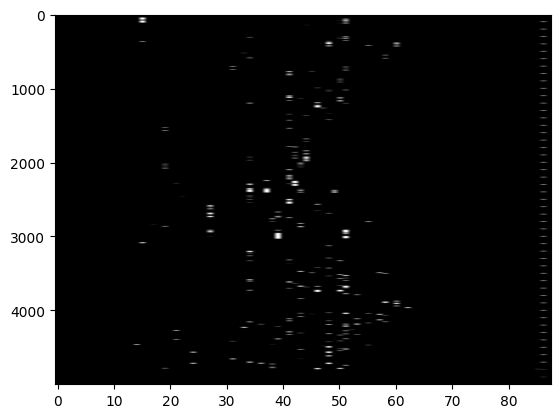

In [43]:
import matplotlib.pyplot as plt
plt.imshow(midi_wav, aspect='auto', cmap='gray')

In [39]:
pm = _

In [67]:
# MusicXML로 변환
# apt install lilypond
from music21 import converter
import os
output_dir = "./data/outputs"
os.makedirs(output_dir, exist_ok=True)
output_roll_midi_path = os.path.join(output_dir, "pm_roll.midi")
output_midi_path = os.path.join(output_dir, "pm.midi")
pm_roll.write(output_roll_midi_path)
pm_midi.write(output_midi_path)

# MusicXML 데이터를 악보로 변환
roll_score = converter.parse(output_roll_midi_path)
# midi_score = converter.parse(output_midi_path)
# score.write('png', 'output')
# roll_pdf = os.path.join(output_dir, "roll_sheet")
roll_png = os.path.join(output_dir, "original")
# midi_pdf = os.path.join(output_dir, "midi_sheet")
converter.subConverters.ConverterLilypond().write(roll_score, fmt='png', fp=roll_png, subformats='png')
# converter.subConverters.ConverterLilypond().write(roll_score, fmt='pdf', fp=roll_pdf, subformats='pdf')
# converter.subConverters.ConverterLilypond().write(midi_score, fmt='pdf', fp=midi_pdf, subformats='pdf')
for file in glob.glob(output_dir + "/*[!pdf|!png]"):
    os.remove(file)

Changing working directory to: `data/outputs'
Processing `data/outputs/original'
Parsing...
Interpreting music...[8][16][24][32][40][48][56][64][72]
Preprocessing graphical objects...
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/original:280:25: warning: ignoring too many clashing note columns
                      < 
                        cis''  g''  > 16   
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/original:146:32: warning: ignoring too many clashing note columns
               << \new Voice { 
                               f'' 16  
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/original:82:25: warning: ignoring too many clashing note columns
                      < 
                        c'''  c''''  > 16   
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/original:362:23: warning: ignoring too many clashing note columns
                      
                      ees'' 16  
/opt/ml/level3_cv_finalproject-cv-08/data/outputs/original:447:25: warning: ignoring t

In [33]:
for file in glob.glob(output_dir + "/*[!pdf|!png]"):
    os.remove(file)

In [15]:
converter.subConverters.ConverterLilypond().write(roll_score, fmt='png', fp="roll", subformats='png')

Processing `roll'
Parsing...
Interpreting music...[8]
roll:130:21: warning: unterminated tie
             f'' 1  
                    ~  
[16][24][32][40]
roll:541:22: warning: unterminated tie
             bes' 2  
                     ~  
roll:630:22: warning: unterminated tie
             ees' 4  
                     ~  
[48]
roll:688:34: warning: unterminated tie
             < ees'  ees''  > 1  
                                 ~   
roll:688:34: warning: unterminated tie
             < ees'  ees''  > 1  
                                 ~   
roll:746:22: warning: unterminated tie
             f'' 16  
                     ~  
[56][64][72]
Preprocessing graphical objects...
roll:1161:23: warning: ignoring too many clashing note columns
                      
                      d'''' 16  
roll:899:23: warning: ignoring too many clashing note columns
                      
                      d'''' 16  
roll:692:25: warning: ignoring too many clashing note columns
             

PosixPath('roll.png')

In [34]:
data = open("/opt/ml/level3_cv_finalproject-cv-08/data/outputs/roll_sheet.pdf", 'rb').read()


In [30]:
glob.glob(output_dir + "/*[!pdf|!png]")

['./data/outputs/midi_sheet',
 './data/outputs/pm_roll.midi',
 './data/outputs/pm.midi',
 './data/outputs/roll_sheet']

In [21]:
file_to_remove

['./roll-24.eps',
 './roll-5.eps',
 './roll-4.eps',
 './roll-3.eps',
 './roll-6.eps',
 './roll-7.eps',
 './roll-21.eps',
 './roll-14.eps',
 './roll-15.eps',
 './roll-20.eps',
 './roll-systems.texi',
 './roll-2.eps',
 './roll-17.eps',
 './roll-systems.count',
 './roll-13.eps',
 './roll-26.eps',
 './roll-11.eps',
 './roll-9.eps',
 './roll-1.eps',
 './roll-12.eps',
 './roll-16.eps',
 './roll-systems.tex',
 './roll-22.eps',
 './roll-18.eps',
 './roll-23.eps',
 './roll-8.eps',
 './roll-19.eps',
 './roll-25.eps',
 './roll-10.eps']

In [8]:
roll.transpose(1, 0).shape

(88, 1250)

In [57]:
from music21 import stream, note, instrument

def create_sheet_music(piano_array):
    # 악보 생성
    sheet_music = stream.Score()
    piano_part = stream.Part()
    piano_part.insert(0, instrument.Piano())

    # 피아노 키와 프레임 수를 반복하여 악보에 음표 추가
    for key_index in range(piano_array.shape[0]):
        for frame_index in range(piano_array.shape[1]):
            if piano_array[key_index, frame_index] == 1:  # 키가 눌려진 경우
                note_obj = note.Note()
                note_obj.pitch.midi = key_index  # MIDI 노트 번호 설정
                note_obj.duration.quarterLength = 1  # 음표 길이 설정
                piano_part.append(note_obj)

    sheet_music.insert(0, piano_part)

    return sheet_music

# 예시 입력 데이터 (0과 1로 이루어진 피아노 배열)

# 악보 생성
sheet_music = create_sheet_music(roll.transpose(1,0))

# 악보 시각화
# sheet_music.show()


In [38]:
sheet_music.classes

('Score',
 'Stream',
 'StreamCore',
 'Music21Object',
 'ProtoM21Object',
 'Generic',
 'object')

In [58]:
from music21 import converter

# MusicXML 파일을 이미지로 변환하여 저장
image_path = "sheet_music"
converter.subConverters.ConverterLilypond().write(sheet_music, fmt='png', fp=image_path, subformats='pdf')

Processing `sheet_music'
Parsing...
Interpreting music...[8][16][24][32][40][48][56][64][72][80][88][96][104][112][120][128][136][144][152][160][168][176][184][192][200][208][216][224][232][240][248][256][264][272][280][288][296][304][312][320][328][336][344][352][360][368][376][384][392][400][408][416][424][432][440][448][456][464][472][480][488][496][504][512][520][528][536][544][552][560][568][576][584][592][600][608][616][624][632][640][648][656][664][672][680][688][696][704][712][720][728][736][744][752][760][768][776][784][792][800][808][816][824][832][840][848][856][864][872][880][888][896]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 10 or 11 pages...
Drawing systems...
Layout output to `sheet_music.ps'...
Converting to `./sheet_music.pdf'...
Success: compilation successfully completed


PosixPath('sheet_music.pdf')

In [52]:
from music21 import converter

# MusicXML 파일 경로
musicxml_path = "sheet_music.xml"

# MusicXML 파일을 이미지로 변환하여 저장
image_path = "sheet_music"
converter.subConverters.ConverterLilypond().write(sheet_music, fmt='png', fp=image_path, subformats=['png'])

Processing `sheet_music.png'
Parsing...
Interpreting music...[8][16][24][32][40][48][56][64][72][80][88][96][104][112][120][128][136][144][152][160]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `sheet_music.png.eps'...
Converting to PNG...
Layout output to `sheet_music.png-1.eps'...
Layout output to `sheet_music.png-2.eps'...
Layout output to `sheet_music.png-3.eps'...
Layout output to `sheet_music.png-4.eps'...
Layout output to `sheet_music.png-5.eps'...
Layout output to `sheet_music.png-6.eps'...
Layout output to `sheet_music.png-7.eps'...
Layout output to `sheet_music.png-8.eps'...
Layout output to `sheet_music.png-9.eps'...
Layout output to `sheet_music.png-10.eps'...
Layout output to `sheet_music.png-11.eps'...
Layout output to `sheet_music.png-12.eps'...
Layout output to `sheet_music.png-13.eps'...
Layout output to `sheet_music.png-14.eps'...
Layout output to `sheet_music.png-15.eps'...
Layout output to `sheet_music.png-16.ep

PosixPath('sheet_music.png.png')

In [50]:
image_path = "sheet_music.png"
converter.subConverters.ConverterMusicXML().write(sheet_music, fmt='png', fp=image_path, subformats=['png'])

SubConverterException: Cannot find a path to the 'mscore' file at /usr/bin/mscore3 -- download MuseScore